In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics
pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv('train.csv',encoding="ISO-8859-1")
test = pd.read_csv('test.csv',encoding="ISO-8859-1")
train.head()

,Id,A1,A2,A3,A4,t0,T0,t1,T1,t2,T2,t3,T3,P3,t4,T4,t5,T5,P5,A19,S6,A21,A22,A23,t7,T7,t8,T8,S9,B1,B2,B3,S10,t11,T11,t12,T12,S13,S14,S15,B12,B13,B14,Result
0,1,300,NaN,405.0,700,6:30:00,25.0,NaN,NaN,8:00:00,100,9:00:00,103,0.2,10:00:00,104.0,11:00:00,105.0,0.2,300,15:00-15:30,40.0,9.0,5.0,15:30:00,70.0,16:00:00,78,0:00-1:00,320.0,3.5,3.5,1:00-2:30,2:30:00,60,4:30:00,40.0,8:00-9:30,10:00-11:30,NaN,800.0,0.15,400,0.900
1,4,300,NaN,405.0,700,14:00:00,24.0,NaN,NaN,15:30:00,100,16:30:00,102,0.2,17:30:00,102.0,18:30:00,102.0,0.2,300,18:30-19:00,40.0,10.0,5.0,19:00:00,70.0,19:30:00,78,4:00-5:30,300.0,3.5,3.5,5:30-6:30,6:30:00,60,12:00:00,40.0,12:00-13:30,14:30-15:00,NaN,800.0,0.15,400,0.896
2,8,300,NaN,405.0,700,3:30:00,21.0,NaN,NaN,5:00:00,100,6:00:00,102,0.2,7:00:00,103.0,8:00:00,105.0,0.2,300,11:30-12:00,40.0,9.0,5.0,12:00:00,70.0,12:30:00,78,19:00-20:00,310.0,3.5,3.5,20:00-21:0,21:00:00,58,0:30:00,40.0,1:00-2:30,3:00-4:30,NaN,800.0,0.15,420,0.930
3,9,300,NaN,405.0,700,15:00:00,21.0,NaN,NaN,16:00:00,100,17:00:00,102,0.2,18:00:00,103.0,19:00:00,104.0,0.2,300,20:30-21:00,40.0,9.0,5.0,21:00:00,71.0,21:30:00,78,3:30-4:30,310.0,3.5,3.5,4:30-6:00,6:00:00,59,12:00:00,40.0,12:00-13:30,14:00-15:00,NaN,800.0,0.15,420,0.935
4,11,300,NaN,405.0,700,6:00:00,20.0,NaN,NaN,7:30:00,100,8:30:00,102,0.2,9:30:00,102.0,10:30:00,102.0,0.2,300,10:30-11:0,40.0,10.0,5.0,11:30:00,70.0,12:00:00,78,23:00-0:0,310.0,3.5,3.5,0:00-1:00,1:00:00,60,3:30:00,40.0,8:00-9:30,10:00-11:30,NaN,800.0,0.15,420,0.923


In [3]:
#将时间信息转化为小时
import re
def t2s(t):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7
        elif t=='1900/1/1 2:30':
            return None
        else:
            return None
    
    try:
        tm = int(t)*3600+int(m)*60+int(s)

    except:
        return None
    
    return tm/3600
for f in ['t0','t2','t3','t4','t5','t7','t8','t11','t12']:
    train[f] = train[f].apply(t2s)

def getStartTime(se):

    try:
        sh,sm,eh,em=re.split("[:,-]",se)
    except:
        if se=='14::30-15:30':
            return 14.5
        elif se=='13；00-14:00':
            return 13
        elif se=='21:00-22；00':
            return 21
        elif se=='22"00-0:00':
            return 22
        elif se=='2:00-3;00':
            return 2
        elif se=='1:30-3;00':
            return 1.5
        elif se=='15:00-1600':
            return 15
        elif se=='19:-20:05':
            return 16
        else:
            return None
        
    try:
        timestart = int(sh)+int(sm)/60
        if timestart >= 24:
            timestart = 0
    except:
        return None
    
    return int(timestart)

train['st6'] = train.apply(lambda df: getStartTime(df['S6']), axis=1)
train['st9'] = train.apply(lambda df: getStartTime(df['S9']), axis=1)
train['st10'] = train.apply(lambda df: getStartTime(df['S10']), axis=1)
train['st13'] = train.apply(lambda df: getStartTime(df['S13']), axis=1)
train['st14'] = train.apply(lambda df: getStartTime(df['S14']), axis=1)
train['st15'] = train.apply(lambda df: getStartTime(df['S15']), axis=1)

# def getNum(se):
#     try:
#         example,num=re.split("[-]",se)
#     except:
#         return None    
#     return int(num)
# train['Id'] = train.apply(lambda df: getNum(df['Id']), axis=1)


def getDuration(se):
    timelasting = 0
    try:
        sh,sm,eh,em=re.split("[:,-]",se)
    except:
        if se=='14::30-15:30':
            return 1
        elif se=='13；00-14:00':
            return 1
        elif se=='21:00-22；00':
            return 1
        elif se=='22"00-0:00':
            return 2
        elif se=='2:00-3;00':
            return 1
        elif se=='1:30-3;00':
            return 1.5
        elif se=='15:00-1600':
            return 1
        elif se=='19:-20:05':
            return 1
        else:
            return None

        
    try:
        if(int(eh)>int(sh)):
            timelasting = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
        elif(int(eh)<int(sh)):
            timelasting = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
    except:
        return None
    return int(timelasting)

for f in ['S6','S9','S10','S13','S14','S15']:
    train[f] = train[f].apply(getDuration)

In [4]:

train.t0[train.t0.isnull()] = train.t0.dropna().mode().values
train.t2[train.t2.isnull()] = train.t2.dropna().mode().values
train.t3[train.t3.isnull()] = train.t3.dropna().mode().values
train.t5[train.t5.isnull()] = train.t5.dropna().mode().values
train.t7[train.t7.isnull()] = train.t7.dropna().mode().values
train.t8[train.t8.isnull()] = train.t8.dropna().mode().values
train.t11[train.t11.isnull()] = train.t11.dropna().mode().values

In [5]:

train.T12[train.T12.isnull()] = train.T12.dropna().mode().values
train.T7[train.T7.isnull()] = train.T7.dropna().mode().values

In [6]:
train.A21[train.A21.isnull()] = train.A21.dropna().mode().values
train.A23[train.A23.isnull()] = train.A23.dropna().mode().values
train.B1[train.B1.isnull()] = train.B1.dropna().mode().values
train.B2[train.B2.isnull()] = train.B2.dropna().mode().values
train.B3[train.B3.isnull()] = train.B3.dropna().mode().values
train.B12[train.B12.isnull()] = train.B12.dropna().mode().values
train.B13[train.B13.isnull()] = train.B13.dropna().mode().values

In [7]:
train.A2[train.A2.notnull()] = 1
train.A3[train.A3.notnull()] = 1
train.A2[train.A2.isnull()] = 0
train.A3[train.A3.isnull()] = 0

In [8]:
train.drop(['t1'], axis=1, inplace=True)
train.drop(['T1'], axis=1, inplace=True)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1396 entries, 0 to 1395
Data columns (total 48 columns):
Id        1396 non-null int64
A1        1396 non-null int64
A2        1396 non-null float64
A3        1396 non-null float64
A4        1396 non-null int64
t0        1396 non-null float64
T0        1396 non-null float64
t2        1396 non-null float64
T2        1396 non-null int64
t3        1396 non-null float64
T3        1396 non-null int64
P3        1396 non-null float64
t4        1396 non-null float64
T4        1396 non-null float64
t5        1396 non-null float64
T5        1396 non-null float64
P5        1396 non-null float64
A19       1396 non-null int64
S6        1386 non-null float64
A21       1396 non-null float64
A22       1396 non-null float64
A23       1396 non-null float64
t7        1396 non-null float64
T7        1396 non-null float64
t8        1396 non-null float64
T8        1396 non-null int64
S9        1395 non-null float64
B1        1396 non-null float64
B2        1

In [10]:
train.head()

,Id,A1,A2,A3,A4,t0,T0,t2,T2,t3,T3,P3,t4,T4,t5,T5,P5,A19,S6,A21,A22,A23,t7,T7,t8,T8,S9,B1,B2,B3,S10,t11,T11,t12,T12,S13,S14,S15,B12,B13,B14,Result,st6,st9,st10,st13,st14,st15
0,1,300,0.0,1.0,700,6.5,25.0,8.0,100,9.0,103,0.2,10.0,104.0,11.0,105.0,0.2,300,0.0,40.0,9.0,5.0,15.5,70.0,16.0,78,1.0,320.0,3.5,3.5,1.0,2.5,60,4.5,40.0,1.0,1.0,NaN,800.0,0.15,400,0.900,15.0,0.0,1.0,8.0,10.0,NaN
1,4,300,0.0,1.0,700,14.0,24.0,15.5,100,16.5,102,0.2,17.5,102.0,18.5,102.0,0.2,300,0.0,40.0,10.0,5.0,19.0,70.0,19.5,78,1.0,300.0,3.5,3.5,1.0,6.5,60,12.0,40.0,1.0,0.0,NaN,800.0,0.15,400,0.896,18.0,4.0,5.0,12.0,14.0,NaN
2,8,300,0.0,1.0,700,3.5,21.0,5.0,100,6.0,102,0.2,7.0,103.0,8.0,105.0,0.2,300,0.0,40.0,9.0,5.0,12.0,70.0,12.5,78,1.0,310.0,3.5,3.5,1.0,21.0,58,0.5,40.0,1.0,1.0,NaN,800.0,0.15,420,0.930,11.0,19.0,20.0,1.0,3.0,NaN
3,9,300,0.0,1.0,700,15.0,21.0,16.0,100,17.0,102,0.2,18.0,103.0,19.0,104.0,0.2,300,0.0,40.0,9.0,5.0,21.0,71.0,21.5,78,1.0,310.0,3.5,3.5,1.0,6.0,59,12.0,40.0,1.0,1.0,NaN,800.0,0.15,420,0.935,20.0,3.0,4.0,12.0,14.0,NaN
4,11,300,0.0,1.0,700,6.0,20.0,7.5,100,8.5,102,0.2,9.5,102.0,10.5,102.0,0.2,300,0.0,40.0,10.0,5.0,11.5,70.0,12.0,78,1.0,310.0,3.5,3.5,1.0,1.0,60,3.5,40.0,1.0,1.0,NaN,800.0,0.15,420,0.923,10.0,23.0,0.0,8.0,10.0,NaN


In [11]:
train.st6[train.st6.isnull()] = train.st6.dropna().mode().values
train.st9[train.st9.isnull()] = train.st9.dropna().mode().values
train.st10[train.st10.isnull()] = train.st10.dropna().mode().values
train.st13[train.st13.isnull()] = train.st13.dropna().mode().values

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1396 entries, 0 to 1395
Data columns (total 48 columns):
Id        1396 non-null int64
A1        1396 non-null int64
A2        1396 non-null float64
A3        1396 non-null float64
A4        1396 non-null int64
t0        1396 non-null float64
T0        1396 non-null float64
t2        1396 non-null float64
T2        1396 non-null int64
t3        1396 non-null float64
T3        1396 non-null int64
P3        1396 non-null float64
t4        1396 non-null float64
T4        1396 non-null float64
t5        1396 non-null float64
T5        1396 non-null float64
P5        1396 non-null float64
A19       1396 non-null int64
S6        1386 non-null float64
A21       1396 non-null float64
A22       1396 non-null float64
A23       1396 non-null float64
t7        1396 non-null float64
T7        1396 non-null float64
t8        1396 non-null float64
T8        1396 non-null int64
S9        1395 non-null float64
B1        1396 non-null float64
B2        1

In [13]:
train = train.drop(train[train['Result']<0.75].index)


 mu = 0.92 and sigma = 0.03



C:\Users\Liu Wenjing\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


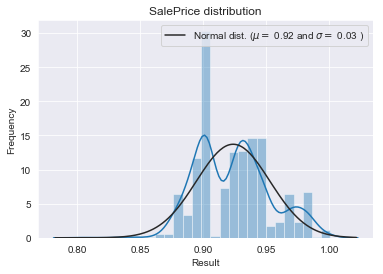

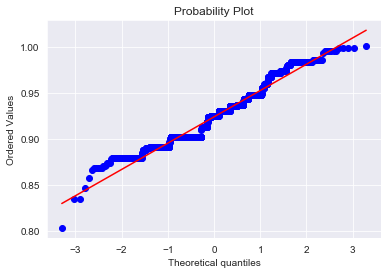

In [14]:
sns.distplot(train['Result'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Result'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['Result'], plot=plt)
plt.show()

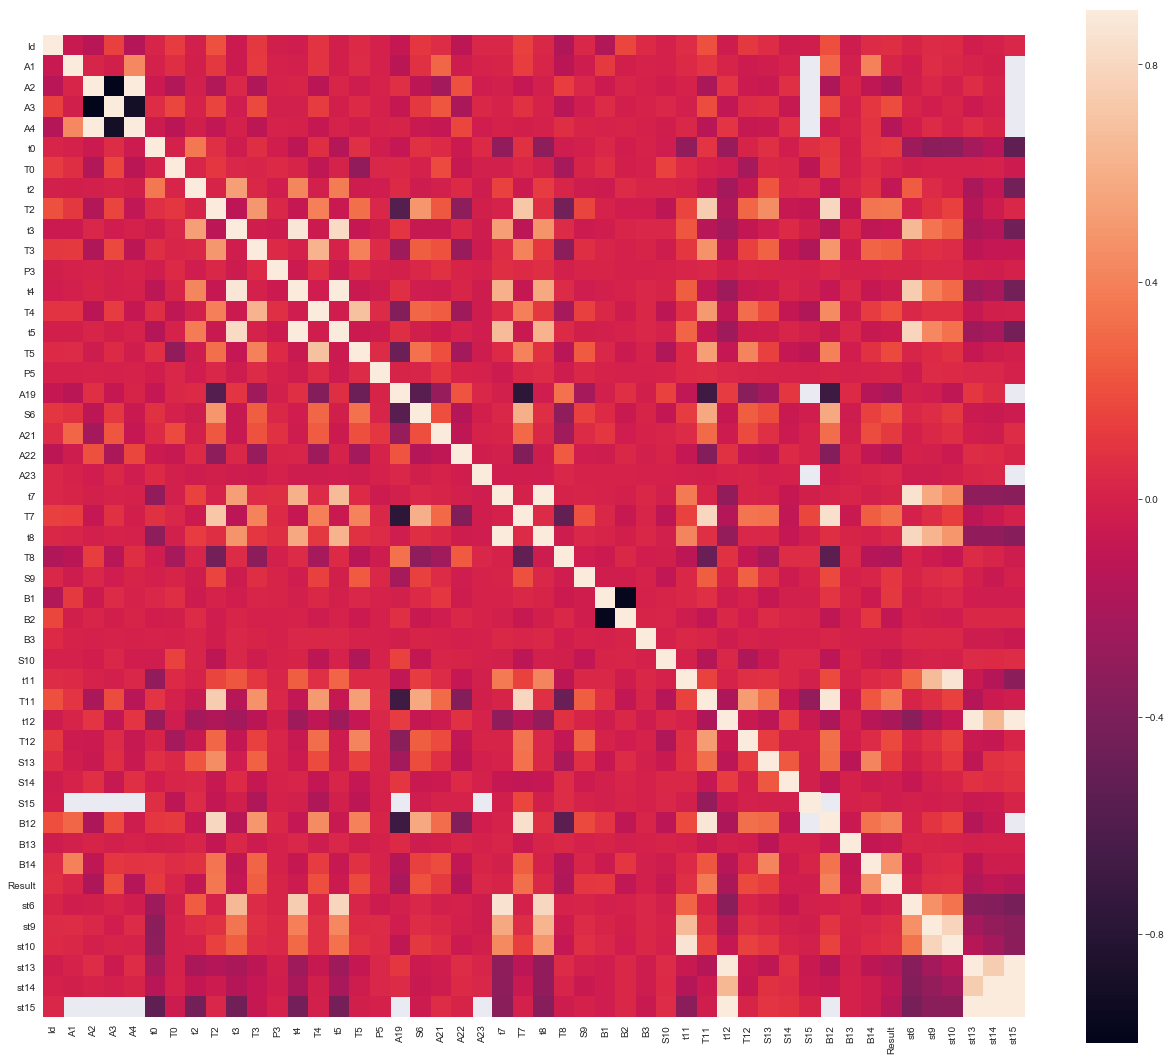

In [15]:
corrmat = train.corr()
plt.subplots(figsize=(22,19))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [16]:
train.st14[train.st14.isnull()] = 24
train.st15[train.st15.isnull()] = 24
train.S14[train.S14.isnull()] = 0
train.S15[train.S15.isnull()] = 0
train[train.isnull()] = 0

In [17]:
train.head()

,Id,A1,A2,A3,A4,t0,T0,t2,T2,t3,T3,P3,t4,T4,t5,T5,P5,A19,S6,A21,A22,A23,t7,T7,t8,T8,S9,B1,B2,B3,S10,t11,T11,t12,T12,S13,S14,S15,B12,B13,B14,Result,st6,st9,st10,st13,st14,st15
0,1,300,0.0,1.0,700,6.5,25.0,8.0,100,9.0,103,0.2,10.0,104.0,11.0,105.0,0.2,300,0.0,40.0,9.0,5.0,15.5,70.0,16.0,78,1.0,320.0,3.5,3.5,1.0,2.5,60,4.5,40.0,1.0,1.0,0.0,800.0,0.15,400,0.900,15.0,0.0,1.0,8.0,10.0,24.0
1,4,300,0.0,1.0,700,14.0,24.0,15.5,100,16.5,102,0.2,17.5,102.0,18.5,102.0,0.2,300,0.0,40.0,10.0,5.0,19.0,70.0,19.5,78,1.0,300.0,3.5,3.5,1.0,6.5,60,12.0,40.0,1.0,0.0,0.0,800.0,0.15,400,0.896,18.0,4.0,5.0,12.0,14.0,24.0
2,8,300,0.0,1.0,700,3.5,21.0,5.0,100,6.0,102,0.2,7.0,103.0,8.0,105.0,0.2,300,0.0,40.0,9.0,5.0,12.0,70.0,12.5,78,1.0,310.0,3.5,3.5,1.0,21.0,58,0.5,40.0,1.0,1.0,0.0,800.0,0.15,420,0.930,11.0,19.0,20.0,1.0,3.0,24.0
3,9,300,0.0,1.0,700,15.0,21.0,16.0,100,17.0,102,0.2,18.0,103.0,19.0,104.0,0.2,300,0.0,40.0,9.0,5.0,21.0,71.0,21.5,78,1.0,310.0,3.5,3.5,1.0,6.0,59,12.0,40.0,1.0,1.0,0.0,800.0,0.15,420,0.935,20.0,3.0,4.0,12.0,14.0,24.0
4,11,300,0.0,1.0,700,6.0,20.0,7.5,100,8.5,102,0.2,9.5,102.0,10.5,102.0,0.2,300,0.0,40.0,10.0,5.0,11.5,70.0,12.0,78,1.0,310.0,3.5,3.5,1.0,1.0,60,3.5,40.0,1.0,1.0,0.0,800.0,0.15,420,0.923,10.0,23.0,0.0,8.0,10.0,24.0


In [18]:
for f in ['t0','t2','t3','t4','t5','t7','t8','t11','t12']:
    test[f] = test[f].apply(t2s)
test['st6'] = test.apply(lambda df: getStartTime(df['S6']), axis=1)
test['st9'] = test.apply(lambda df: getStartTime(df['S9']), axis=1)
test['st10'] = test.apply(lambda df: getStartTime(df['S10']), axis=1)
test['st13'] = test.apply(lambda df: getStartTime(df['S13']), axis=1)
test['st14'] = test.apply(lambda df: getStartTime(df['S14']), axis=1)
test['st15'] = test.apply(lambda df: getStartTime(df['S15']), axis=1)
for f in ['S6','S9','S10','S13','S14','S15']:
    test[f] = test[f].apply(getDuration)
    
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 50 columns):
Id        150 non-null object
A1        150 non-null int64
A2        3 non-null float64
A3        147 non-null float64
A4        150 non-null int64
t0        149 non-null float64
T0        150 non-null int64
t1        18 non-null object
T1        18 non-null float64
t2        150 non-null float64
T2        150 non-null int64
t3        150 non-null float64
T3        150 non-null float64
P3        150 non-null float64
t4        150 non-null float64
T4        150 non-null float64
t5        150 non-null float64
T5        150 non-null float64
P5        150 non-null float64
A19       150 non-null int64
S6        149 non-null float64
A21       150 non-null int64
A22       150 non-null int64
A23       150 non-null int64
t7        150 non-null float64
T7        149 non-null float64
t8        150 non-null float64
T8        149 non-null float64
S9        146 non-null float64
B1        149 non-

In [19]:
test.t0[test.t0.isnull()] = test.t0.dropna().mode().values
test.t2[test.t2.isnull()] = test.t2.dropna().mode().values
test.t3[test.t3.isnull()] = test.t3.dropna().mode().values
test.t5[test.t5.isnull()] = test.t5.dropna().mode().values
test.t7[test.t7.isnull()] = test.t7.dropna().mode().values
test.t8[test.t8.isnull()] = test.t8.dropna().mode().values
test.t11[test.t11.isnull()] = test.t11.dropna().mode().values

test.T7[test.T7.isnull()] = test.T7.dropna().mode().values
test.T8[test.T8.isnull()] = test.T8.dropna().mode().values
test.T12[test.T12.isnull()] = test.T12.dropna().mode().values

test.A21[test.A21.isnull()] = test.A21.dropna().mode().values
test.A23[test.A23.isnull()] = test.A23.dropna().mode().values

test.B1[test.B1.isnull()] = test.B1.dropna().mode().values
test.B2[test.B2.isnull()] = test.B2.dropna().mode().values
test.B3[test.B3.isnull()] = test.B3.dropna().mode().values
test.B12[test.B12.isnull()] = test.B12.dropna().mode().values
test.B13[test.B13.isnull()] = test.B13.dropna().mode().values

test.A2[test.A2.notnull()] = 1
test.A3[test.A3.notnull()] = 1
test.A2[test.A2.isnull()] = 0
test.A3[test.A3.isnull()] = 0

test.drop(['t1'], axis=1, inplace=True)
test.drop(['T1'], axis=1, inplace=True)

test.st6[test.st6.isnull()] = test.st6.dropna().mode().values
test.st9[test.st9.isnull()] = test.st9.dropna().mode().values
test.st10[test.st10.isnull()] = test.st10.dropna().mode().values
test.st13[test.st13.isnull()] = test.st13.dropna().mode().values

test.st14[test.st14.isnull()] = 24
test.st15[test.st15.isnull()] = 24

test.S6[test.S6.isnull()] = 0
test.S9[test.S9.isnull()] = 0
test.S10[test.S10.isnull()] = 0
test.S13[test.S13.isnull()] = 0
test.S14[test.S14.isnull()] = 0
test.S15[test.S15.isnull()] = 0
 
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1394 entries, 0 to 1395
Data columns (total 48 columns):
Id        1394 non-null int64
A1        1394 non-null int64
A2        1394 non-null float64
A3        1394 non-null float64
A4        1394 non-null int64
t0        1394 non-null float64
T0        1394 non-null float64
t2        1394 non-null float64
T2        1394 non-null int64
t3        1394 non-null float64
T3        1394 non-null int64
P3        1394 non-null float64
t4        1394 non-null float64
T4        1394 non-null float64
t5        1394 non-null float64
T5        1394 non-null float64
P5        1394 non-null float64
A19       1394 non-null int64
S6        1394 non-null float64
A21       1394 non-null float64
A22       1394 non-null float64
A23       1394 non-null float64
t7        1394 non-null float64
T7        1394 non-null float64
t8        1394 non-null float64
T8        1394 non-null int64
S9        1394 non-null float64
B1        1394 non-null float64
B2        1

In [20]:
train = train.drop(['Id'],axis = 1)
test = test.drop(['Id'],axis = 1)
train_x = train.drop(['Result'],axis = 1)
train_y = train['Result'].values

test_x = test.drop(['Result'],axis = 1)
 

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1394 entries, 0 to 1395
Data columns (total 47 columns):
A1        1394 non-null int64
A2        1394 non-null float64
A3        1394 non-null float64
A4        1394 non-null int64
t0        1394 non-null float64
T0        1394 non-null float64
t2        1394 non-null float64
T2        1394 non-null int64
t3        1394 non-null float64
T3        1394 non-null int64
P3        1394 non-null float64
t4        1394 non-null float64
T4        1394 non-null float64
t5        1394 non-null float64
T5        1394 non-null float64
P5        1394 non-null float64
A19       1394 non-null int64
S6        1394 non-null float64
A21       1394 non-null float64
A22       1394 non-null float64
A23       1394 non-null float64
t7        1394 non-null float64
T7        1394 non-null float64
t8        1394 non-null float64
T8        1394 non-null int64
S9        1394 non-null float64
B1        1394 non-null float64
B2        1394 non-null float64
B3       

In [22]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [23]:
#Validation function
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train_x.values, train_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [24]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.0253 (0.0091)



In [25]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

 Averaged base models score: 0.0376 (0.0239)



In [26]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))


def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))/(2*len(y))


stacked_averaged_models.fit(train_x.values, train_y)
stacked_train_pred = stacked_averaged_models.predict(train_x)
stacked_pred = stacked_averaged_models.predict(test_x)
print(rmsle(train_y, stacked_train_pred))

model_xgb.fit(train_x, train_y)
xgb_train_pred = model_xgb.predict(train_x)
xgb_pred = model_xgb.predict(test_x)
print(rmsle(train_y, xgb_train_pred))

model_lgb.fit(train_x, train_y)
lgb_train_pred = model_lgb.predict(train_x)
lgb_pred = model_lgb.predict(test_x)
print(rmsle(train_y, lgb_train_pred))

'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(train_y,stacked_train_pred*0.80 +
               xgb_train_pred*0.05 + lgb_train_pred*0.15 ))

Stacking Averaged models score: 0.0159 (0.0034)
3.6313633423912537e-06
7.652968185432102e-06
4.297733964157286e-06
RMSLE score on train data:
3.7898390585338905e-06


In [27]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

prediction = pd.DataFrame(ensemble, columns=['SalePrice'])
test = pd.read_csv('test.csv',encoding="ISO-8859-1")
result = pd.concat([test['Id'], prediction], axis=1)
result.to_csv('./Predictions3_sum.csv', index=False)

In [28]:
prediction = pd.DataFrame(stacked_train_pred, columns=['SalePrice'])
test = pd.read_csv('test.csv',encoding="ISO-8859-1")
result = pd.concat([test['Id'], prediction], axis=1)
result.to_csv('./Predictions4_max.csv', index=False)

In [42]:
def rmse(predictions, targets):
    return ((predictions - targets) ** 2).mean()/2

In [44]:
print(rmse(train_y, stacked_train_pred))
print(rmse(train_y, xgb_train_pred))
print(rmse(train_y, lgb_train_pred))

5.125012789873307e-05
0.00022762258913476514
7.178514802697489e-05


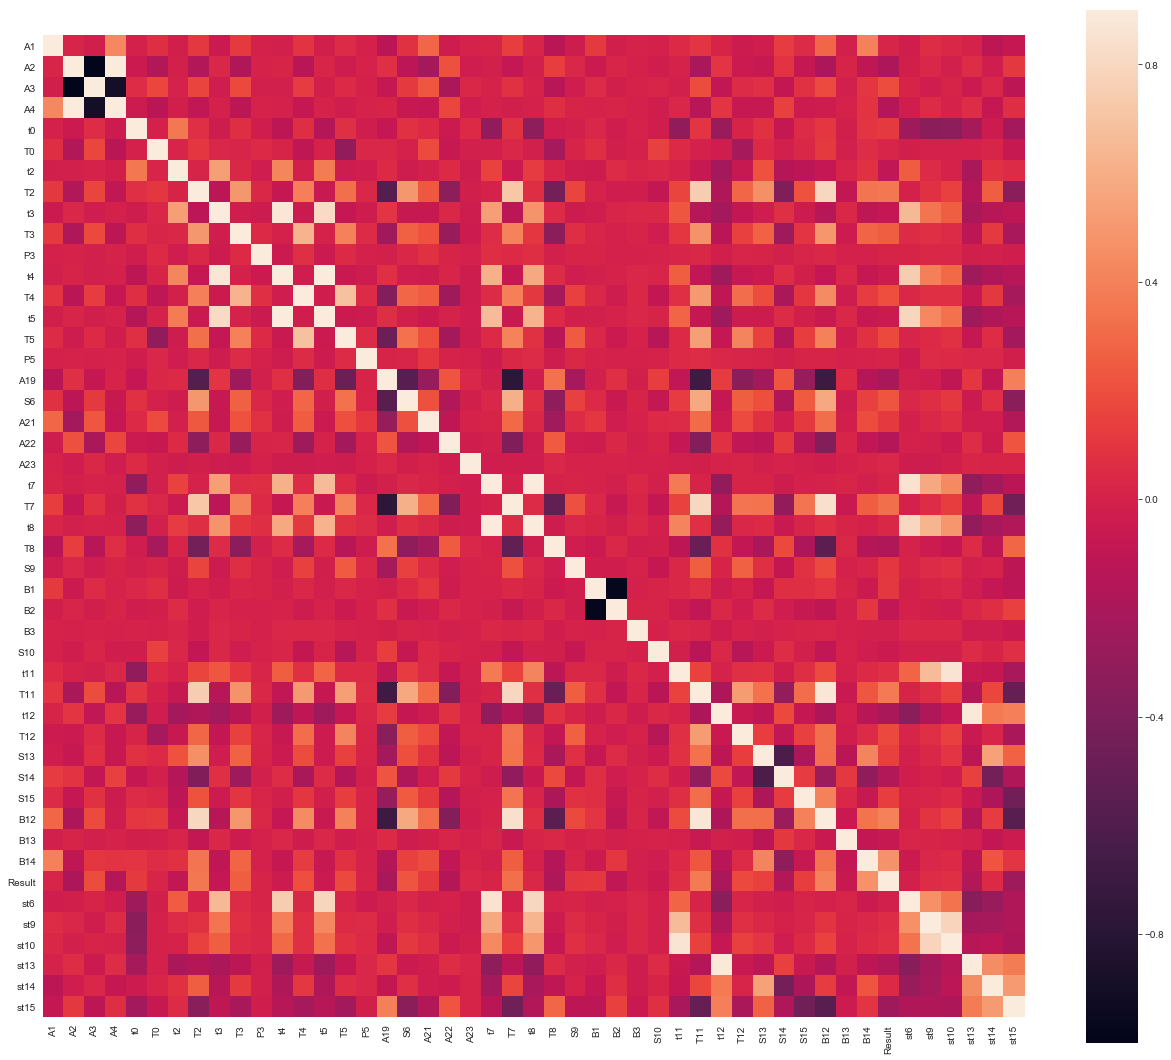

In [45]:
corrmat = train.corr()
plt.subplots(figsize=(22,19))
sns.heatmap(corrmat, vmax=0.9, square=True)